In [1]:
import sys
from pathlib import Path

# Add parent directory to path so we can import src
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


Load processed data

In [2]:
import pandas as pd
df = pd.read_parquet('/Users/pravinjadhav/Desktop/Pravin/fuel price optimizer/notebook/data/processed/processed.parquet')
df.shape



(729, 23)

Train-test split (time-based)

In [ ]:
train = df[df['date'] < '2024-09-01']
test = df[df['date'] >= '2024-09-01']


In [3]:
# Example: last 3 months as test (adjust to your dataset)
split_date = df['date'].max() - pd.Timedelta(days=90)
train = df[df['date'] <= split_date]
test = df[df['date'] > split_date]
len(train), len(test)


(639, 90)

Train model

In [4]:
from src.models import train_demand_model, default_feature_columns
feature_cols = default_feature_columns(train)
model, feature_cols = train_demand_model(train, feature_cols=feature_cols)
print("Trained with features:", feature_cols)


Trained with features: ['price', 'price_diff', 'comp_mean', 'comp_max', 'comp_min', 'vol_ma7', 'vol_ma30', 'vol_lag1', 'vol_lag7', 'price_ma7', 'price_lag1', 'dayofweek', 'is_weekend', 'month', 'margin', 'margin_pct']


Evaluation

In [5]:
from src.models import evaluate_model
print("Train:", evaluate_model(model, feature_cols, train))
print("Test:", evaluate_model(model, feature_cols, test))


Train: {'rmse': 64.58331624200835, 'mae': 44.94980866099374}
Test: {'rmse': 777.1599358300522, 'mae': 563.4006727430556}


Backtest simulation (day-by-day predicted profit uplift)

In [6]:
from src.optimizer import recommend_price
hist = df[df['date'] < '2024-09-01']  # frozen history for simulation start
results = []
model_loaded, feat_cols = model, feature_cols
# Use sliding window from test[0] to test[-1]
for idx, row in test.iterrows():
    today = {
        'date': str(row['date'].date()),
        'cost': float(row['cost']),
        'comp1': float(row.get('comp1', row.get('comp_mean'))),
        'comp2': float(row.get('comp2', row.get('comp_mean'))),
        'comp3': float(row.get('comp3', row.get('comp_mean'))),
        'last_price': float(hist.iloc[-1]['price'])
    }
    rec, candidates = recommend_price(today, hist, model=model_loaded, feature_cols=feat_cols, guardrails={'max_change_pct':0.03,'min_margin':1.0,'max_vs_comp_pct':0.1})
    # compute predicted profit for historical price using same demand model (counterfactual consistency)
    from src.features import compute_features_for_candidate
    feat_hist = compute_features_for_candidate(pd.Series(today), row['price'])
    # build DataFrame shape expected
    import pandas as pd
    hdf = pd.DataFrame([feat_hist])
    # ensure feature columns present
    for c in feat_cols:
        if c not in hdf.columns:
            hdf[c]=0.0
    import numpy as np
    pred_vol_hist = model_loaded.predict(hdf[feat_cols].values)[0]
    profit_hist = (row['price'] - row['cost'])*pred_vol_hist
    results.append({
        'date': today['date'],
        'hist_price': float(row['price']),
        'rec_price': rec['recommended_price'],
        'hist_profit': float(profit_hist),
        'rec_profit': float(rec['expected_profit'])
    })
    # append today's actual row to hist so next iteration has more history
    hist = pd.concat([hist, row.to_frame().T], ignore_index=True)


Aggregate results & plots

Avg daily uplift: 35670.15347893206


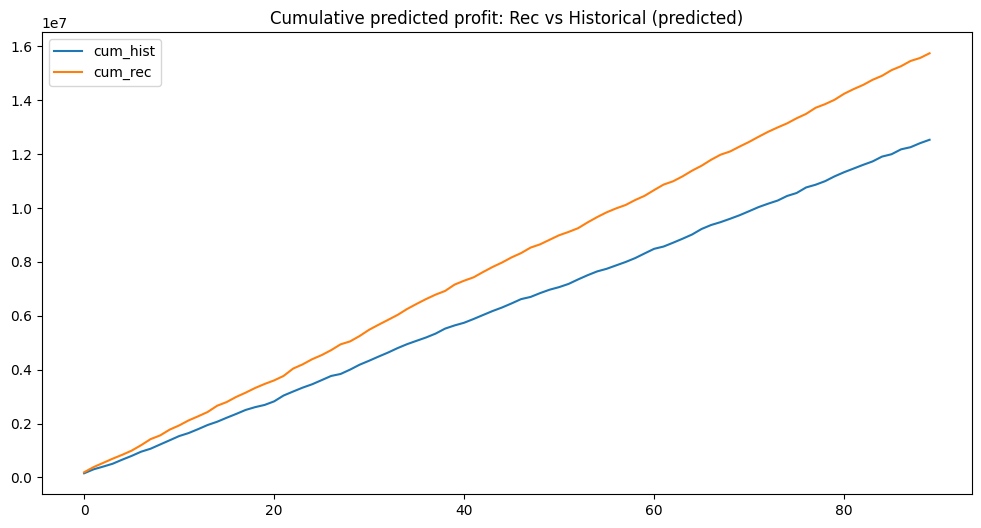

In [7]:
resdf = pd.DataFrame(results)
resdf['profit_diff'] = resdf['rec_profit'] - resdf['hist_profit']
resdf['cum_hist'] = resdf['hist_profit'].cumsum()
resdf['cum_rec'] = resdf['rec_profit'].cumsum()
resdf[['cum_hist','cum_rec']].plot(figsize=(12,6), title='Cumulative predicted profit: Rec vs Historical (predicted)')
print("Avg daily uplift:", resdf['profit_diff'].mean())
